In [1]:
from __future__ import print_function
from __future__ import absolute_import

In [2]:
import os
import tensorflow as tf

/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sracela/miniconda3/envs/p2c/lib/python3.6/s

In [3]:
tf.enable_eager_execution()

In [4]:
tf.executing_eagerly()

True

### GPU

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [6]:
tf.test.is_gpu_available()

True

In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Dataset

In [9]:
from classes.Vocabulary import *
from classes.Utils import *

### Images and captions

Transformed images in training dataset to numpy arrays already provided in 

../datasets/web/training_features

Normalized pixel values and resized pictures 

In [10]:
# Store captions and image names in vectors
# Preprocess the images && Preprocess and tokenize the captions

input_path = '../datasets/android/training_features'
output_path = '../bin'

## Initialize Image model and load the pretrained Imagenet weights

### Dataset class

In [11]:
def clean_sequence(token_sequence):
    new_sequence = [ x for x in token_sequence if x is not '\n']
    sequence_no_comas = [ x for x in new_sequence if x is not ',']
    sequence_no_arrows = [ x for x in sequence_no_comas if x is not '{']
    sequence_no_arrows = [ x for x in sequence_no_arrows if x is not '}']
    del sequence_no_arrows[1]
    return sequence_no_arrows

In [12]:
class Dataset:
    def __init__(self):
        self.input_shape = None
        self.output_size = None

        self.ids = []
        self.input_images = []
        self.total_sequences = []
        
        self.voc = Vocabulary()
        self.size = 0
    def load(self, path, generate_binary_sequences=False):
        print("Loading data...")
        for f in os.listdir(path):
            if f.find(".gui") != -1:
                gui = open("{}/{}".format(path, f), 'r')
                file_name = f[:f.find(".gui")]

                if os.path.isfile("{}/{}.png".format(path, file_name)):
                    img = Utils.get_preprocessed_img("{}/{}.png".format(path, file_name), IMAGE_SIZE)
                    self.append(file_name, gui, img)
                elif os.path.isfile("{}/{}.npz".format(path, file_name)):
                    img = np.load("{}/{}.npz".format(path, file_name))["features"]
                    self.append(file_name, gui, img)

        print("Generating sparse vectors...")
        self.voc.create_binary_representation()
        if generate_binary_sequences:
            self.total_sequences = self.binarize(self.total_sequences, self.voc)
        else:
            self.total_sequences = self.indexify(self.total_sequences, self.voc)
        
        self.size = len(self.ids)
        assert self.size == len(self.input_images) == len(self.total_sequences)
        assert self.voc.size == len(self.voc.vocabulary)
        
        self.voc.save(output_path)
        
        print("Dataset size: {}".format(self.size))
        print("Vocabulary size: {}".format(self.voc.size))

        self.input_shape = self.input_images[0].shape
        self.output_size = self.voc.size

        print("Input shape: {}".format(self.input_shape))
        print("Output size: {}".format(self.output_size))

    def append(self, sample_id, gui, img, to_show=False):
        if to_show:
            pic = img * 255
            pic = np.array(pic, dtype=np.uint8)
            Utils.show(pic)

        token_sequence = [START_TOKEN]
        for line in gui:
            line = line.replace(",", " ,").replace("\n", " \n")
            tokens = line.split(" ")
            for token in tokens:
                # self.voc.append(token)
                token_sequence.append(token)
        token_sequence.append(END_TOKEN)
        # new dataset
        token_sequence = clean_sequence(token_sequence)
        for token in token_sequence:
            self.voc.append(token)
        
        self.ids.append(sample_id)
        self.input_images.append(img)
        self.total_sequences.append(token_sequence)

    @staticmethod
    def indexify(partial_sequences, voc):
        temp = []
        for sequence in partial_sequences:
            sparse_vectors_sequence = []
            for token in sequence:
                sparse_vectors_sequence.append(voc.vocabulary[token])
            temp.append(np.array(sparse_vectors_sequence))

        return temp                

In [13]:
# Load caption annotation files and image files in Dataset
raw_dataset = Dataset()
raw_dataset.load(input_path)

Loading data...
Generating sparse vectors...
Dataset size: 1500
Vocabulary size: 14
Input shape: (256, 256, 3)
Output size: 14


In [14]:
raw_dataset.total_sequences[0]

array([0, 2, 3, 4, 2, 3, 5, 3, 6, 7, 7, 1])

### Image model VGG16

#### CoordConv

In [15]:
from tensorflow.python.keras.engine import base_layer

In [16]:
class AddCoords(base_layer.Layer):
    """Add coords to a tensor"""
    def __init__(self, x_dim=256, y_dim=256, with_r=False, skiptile=True, **kwargs):
        super(AddCoords, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r
        self.skiptile = skiptile


    def call(self, input_tensor):
        """
        input_tensor: (batch, 1, 1, c), or (batch, x_dim, y_dim, c)
        In the first case, first tile the input_tensor to be (batch, x_dim, y_dim, c)
        In the second case, skiptile, just concat
        """
        if not self.skiptile:
            input_tensor = tf.tile(input_tensor, [1, self.x_dim, self.y_dim, 1]) # (batch, 64, 64, 2)
            input_tensor = tf.cast(input_tensor, 'float32')

        batch_size_tensor = tf.shape(input_tensor)[0]  # get batch size

        xx_ones = tf.ones([batch_size_tensor, self.x_dim], 
                          dtype=tf.int32)                       # e.g. (batch, 64)
        xx_ones = tf.expand_dims(xx_ones, -1)                   # e.g. (batch, 64, 1)
        xx_range = tf.tile(tf.expand_dims(tf.range(self.y_dim), 0), 
                            [batch_size_tensor, 1])             # e.g. (batch, 64)
        xx_range = tf.expand_dims(xx_range, 1)                  # e.g. (batch, 1, 64)


        xx_channel = tf.matmul(xx_ones, xx_range)               # e.g. (batch, 64, 64)
        xx_channel = tf.expand_dims(xx_channel, -1)             # e.g. (batch, 64, 64, 1)


        yy_ones = tf.ones([batch_size_tensor, self.y_dim], 
                          dtype=tf.int32)                       # e.g. (batch, 64)
        yy_ones = tf.expand_dims(yy_ones, 1)                    # e.g. (batch, 1, 64)
        yy_range = tf.tile(tf.expand_dims(tf.range(self.x_dim), 0),
                            [batch_size_tensor, 1])             # (batch, 64)
        yy_range = tf.expand_dims(yy_range, -1)                 # e.g. (batch, 64, 1)

        yy_channel = tf.matmul(yy_range, yy_ones)               # e.g. (batch, 64, 64)
        yy_channel = tf.expand_dims(yy_channel, -1)             # e.g. (batch, 64, 64, 1)

        xx_channel = tf.cast(xx_channel, 'float32') / (self.x_dim - 1)
        yy_channel = tf.cast(yy_channel, 'float32') / (self.y_dim - 1)
        xx_channel = xx_channel*2 - 1                           # [-1,1]
        yy_channel = yy_channel*2 - 1

        ret = tf.concat([input_tensor, 
                         xx_channel, 
                         yy_channel], axis=-1)    # e.g. (batch, 64, 64, c+2)

        if self.with_r:
            rr = tf.sqrt( tf.square(xx_channel)
                    + tf.square(yy_channel)
                    )
            ret = tf.concat([ret, rr], axis=-1)   # e.g. (batch, 64, 64, c+3)

        return ret
class CoordConv(base_layer.Layer):
    """CoordConv layer as in the paper."""
    def __init__(self, x_dim, y_dim, with_r, *args,  **kwargs):
        super(CoordConv, self).__init__()
        self.addcoords = AddCoords(x_dim=x_dim, 
                                   y_dim=y_dim, 
                                   with_r=with_r,
                                   skiptile=True)
        self.conv = tf.keras.layers.Conv2D(3, 3, padding='same')

    def call(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret

In [17]:
coordconv = CoordConv(x_dim=256, y_dim=256, with_r=False, skiptile=True)

In [18]:
is_coordconv = False

In [19]:
orig_model = tf.keras.applications.VGG16(
include_top=False, weights='imagenet')
dense_input = tf.keras.layers.Input(shape=(256, 256, 3))
dense_filter = coordconv(dense_input)
output = orig_model(dense_filter)

#### VGG

In [20]:
VGG_OUT_LOOP = True

In [21]:
image_model = tf.keras.applications.VGG16(
include_top=False, weights='imagenet', input_shape=(256, 256, 3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

In [22]:
if is_coordconv:
    image_features_extract_model = tf.keras.Model(dense_input, output)
    dense_input, output
else:
    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    new_input, hidden_layer

In [23]:
image_dataset = []
if VGG_OUT_LOOP:
#     image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    for img in raw_dataset.input_images:
        img = img.reshape([1] + list(raw_dataset.input_shape))
        img_features = image_features_extract_model(img)
        img_features = tf.reshape(img_features,
    (img_features.shape[0], -1, img_features.shape[3]))
        img_features = tf.squeeze(
        img_features, axis=None, name=None)
        image_dataset.append(img_features)
else: 
    for img in raw_dataset.input_images:
        image_dataset.append(img)

In [24]:
# shape=(64, 512)
image_dataset[0].shape

TensorShape([Dimension(64), Dimension(512)])

## Preprocess and tokenize the captions

In [25]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [26]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(raw_dataset.total_sequences, padding='post')

In [27]:
cap_vector[0]

array([0, 2, 3, 4, 2, 3, 5, 3, 6, 7, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [28]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(raw_dataset.total_sequences)
max_length

37

In [29]:
voc = Vocabulary()
voc.retrieve(output_path)
voc.size

{'<START>': 0, '<END>': 1, 'row': 2, 'label': 3, 'btn': 4, 'slider': 5, 'footer': 6, 'btn-notifications': 7, 'switch': 8, 'btn-dashboard': 9, 'btn-search': 10, 'radio': 11, 'check': 12, 'btn-home': 13}


14

## Split the data into training and testing

### Notas
- Fijar Random Seed !!!!

In [30]:
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [31]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_dataset,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(1200, 1200, 300, 300)

## Create a tf.data dataset for training

In [33]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 24

embedding_dim = 128
units = 512
vocab_size = 14

num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 512)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 64

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [35]:
# Batch
dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# Model

In [36]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features es el CNN_encoder output shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # tienes 1 en el last axis porque aplicas score a self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [37]:
if VGG_OUT_LOOP:
    class CNN_Encoder(tf.keras.Model):
        # Commo ya se extrajeron las features sólo se pasan por una FC
        def __init__(self, embedding_dim):
            super(CNN_Encoder, self).__init__()
            # fc == (batch_size, 64, embedding_dim)
            self.fc = tf.keras.layers.Dense(embedding_dim)

        def call(self, x):
            x = self.fc(x)
  #         x = tf.nn.relu(x)
            return x
else:
    class CNN_Encoder(tf.keras.Model):
        def __init__(self, embedding_dim):
            super(CNN_Encoder, self).__init__()
    #       self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
            self.image_model = image_features_extract_model
            # fc == (batch_size, 64, embedding_dim)
            self.fc = tf.keras.layers.Dense(embedding_dim)

        def call(self, x):
    #       x = self.image_features_extract_model(x)
            x = self.image_model(x) 
            x = tf.reshape(x,(x.shape[0], -1, x.shape[3]))
    #       x = tf.squeeze(x, axis=None, name=None)
            x = self.fc(x)
            return x

In [38]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # attention
        context_vector, attention_weights = self.attention(features, hidden)

        # despues de embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # despues de concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # pasar x a la GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        
        # relu added - con softmax!!
#         x = tf.nn.relu(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [39]:
# class Pix2Code(tf.keras.Model):
#     def __init__(self, encoder, decoder):
#         super(Pix2Code, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def train_step(self, inputs):
#         loss = 0

#         img_tensor = inputs[0]
#         target = inputs[1]

#         # initializing the hidden state for each batch
#         hidden = self.decoder.reset_state(batch_size=target.shape[0])

#         dec_input = tf.expand_dims([0] * target.shape[0], 1)

#         with tf.GradientTape() as tape:

#             features = self.encoder(img_tensor)

#             for i in range(1, target.shape[1]):
#                 # passing the features through the decoder
#                 predictions, hidden, _ = decoder(dec_input, features, hidden)

#                 loss += self.compiled_loss(target[:, i], predictions)

#                 # using teacher forcing
#                 dec_input = tf.expand_dims(target[:, i], 1)

#         total_loss = (loss / int(target.shape[1]))

#         trainable_variables = encoder.trainable_variables + decoder.trainable_variables

#         gradients = tape.gradient(loss, trainable_variables)

#         self.optimizer.apply_gradients(zip(gradients, trainable_variables))

# #         return loss, total_loss
#         return {"loss": loss}


In [40]:
# encoder = CNN_Encoder(embedding_dim)
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [41]:
# optimizer = tf.keras.optimizers.Adam() 
optimizer = tf.keras.optimizers.Adam(lr=0.0001, epsilon=1e-07) 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # mirar si el va el softmax incorporado 

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [42]:
# pix2code = Pix2Code(encoder=encoder, decoder=decoder)
# pix2code.compile(optimizer=optimizer, loss=loss_function)
# pix2code.fit(dataset.take(100), epochs=5)

### Checkpoint

In [43]:
model_name = 'vgg_out_loop'

In [44]:
checkpoint_path = "{}/checkpoints/{}".format(output_path, model_name)
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [45]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Train the model

In [46]:
# for (batch, (img_tensor, target)) in enumerate(dataset): 
#     loss = 0
#     hidden = decoder.reset_state(batch_size=target.shape[1])
#     dec_input = tf.expand_dims([START_TOKEN] * target.shape[1], 1)
#     with tf.GradientTape() as tape:
#         features = encoder(img_tensor)
#         for i in range(1, target.shape[1]):
#             # passing the features through the decoder
#             print(dec_input, features_aux, hidden)
#             predictions, hidden, _ = decoder(dec_input, features, hidden)
#             print(predictions, hidden)
#             loss += loss_function(target[:, i], predictions)
#             dec_input = tf.expand_dims(target[:, i], 1)
#             print("")
#             print("DECODER INPUT {}".format(dec_input))
#             print("loss {}".format(loss))
#             print("")
#         total_loss = (loss / int(target.shape[1]))
#         print("")
#         print("TOTAL LOSS {}".format(total_loss))
#         trainable_variables = encoder.trainable_variables + decoder.trainable_variables
#         print("ENCODER TRAINABLE VAR  {}".format(encoder.trainable_variables))
#         print("DECODER TRAINABLE VAR  {}".format(decoder.trainable_variables))
#         print("TRAINABLE VAR {}".format(trainable_variables))
#         print("")
#         gradients = tape.gradient(loss, trainable_variables)
#         print("GRADIENTS {}".format(gradients))
#         optimizer.apply_gradients(zip(gradients, trainable_variables)
    

In [47]:
import time
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

### Notas
- Hidden: inicializar con la media

In [48]:
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([0] * target.shape[0], 1)

    with tf.GradientTape() as tape:

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [49]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    diff_plot = 100

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    #Early stopping
    if epoch > 2:
        diff_plot = loss_plot[-1] - loss_plot[-2]
        print('Diff loss {}'.format(diff_plot))
    if abs(diff_plot) <= 0.001:
        ckpt_manager.save()
        print('Early stopping STOP')
        break

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 1.1691
Epoch 1 Loss 1.142246
Time taken for 1 epoch 40.63220429420471 sec

Epoch 2 Batch 0 Loss 1.0057
Epoch 2 Loss 1.055355
Time taken for 1 epoch 38.725380182266235 sec

Epoch 3 Batch 0 Loss 0.9031
Epoch 3 Loss 0.876100
Time taken for 1 epoch 38.60607719421387 sec

Epoch 4 Batch 0 Loss 0.7079
Epoch 4 Loss 0.677521
Time taken for 1 epoch 38.43809175491333 sec

Diff loss -0.19857925176620483
Epoch 5 Batch 0 Loss 0.5669
Epoch 5 Loss 0.597750
Time taken for 1 epoch 38.62251591682434 sec

Diff loss -0.07977086305618286
Epoch 6 Batch 0 Loss 0.5325
Epoch 6 Loss 0.572394
Time taken for 1 epoch 38.93247365951538 sec

Diff loss -0.025356411933898926
Epoch 7 Batch 0 Loss 0.5144
Epoch 7 Loss 0.556803
Time taken for 1 epoch 38.431819915771484 sec

Diff loss -0.015591025352478027
Epoch 8 Batch 0 Loss 0.5008
Epoch 8 Loss 0.541683
Time taken for 1 epoch 38.821884870529175 sec

Diff loss

In [50]:
import matplotlib.pyplot as plt

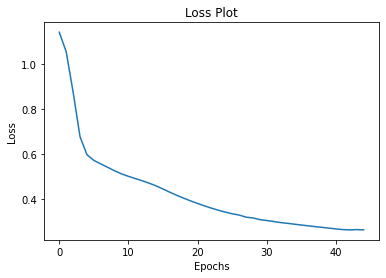

In [51]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Save weights

In [52]:
tf.__version__

'1.14.0'

In [53]:
# encoder.get_config()

In [54]:
# w_path = "{}/notebook".format(output_path)
# # encoder._set_inputs(hidden_layer)
# # decoder._set_inputs(hidden_layer)
# tf.keras.experimental.export_saved_model(encoder, "{}/encoder".format(w_path), serving_only=True)
# # encoder.save("{}/encoder".format(w_path),save_format='tf')
# # decoder.save("{}/encoder".format(w_path),save_format='tf')
# # encoder.save_weights("{}/encoder".format(w_path), save_format="h5")
# # decoder.save_weights("{}/decoder".format(w_path), save_format="h5")  

In [55]:
# encoder.summary()

In [56]:
# new_model = tf.keras.experimental.load_from_saved_model("{}/encoder".format(w_path))
# new_model.summary()

In [57]:
# del encoder  # deletes the existing model
# del decoder

## Evaluate

In [58]:
# encoder = CNN_Encoder(embedding_dim)
# decoder = RNN_Decoder(embedding_dim, units, vocab_size)
# encoder.load_weights("{}/encoder".format(w_path))
# decoder.load_weights("{}/decoder".format(w_path))
# encoder = tf.keras.models.load_model("{}/encoder".format(w_path))
# decoder = tf.keras.models.load_model("{}/decoder".format(w_path))

In [59]:
from PIL import Image


### Evaluation Dataset

In [60]:
eval_path = '../datasets/android/eval_set'

In [61]:
IMAGE_SIZE = 256
max_length= 37
attention_features_shape = 64

In [62]:
# Load caption annotation files and image files in Dataset
eval_raw_dataset = Dataset()
eval_raw_dataset.load(eval_path)

Loading data...
Generating sparse vectors...
Dataset size: 250
Vocabulary size: 14
Input shape: (256, 256, 3)
Output size: 14


In [63]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    
#     image = image.reshape([1] + list(raw_dataset.input_shape))    
#     temp_input = tf.expand_dims(image[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)

    dec_input = tf.expand_dims([0], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #escoger el máx

        result.append(voc.token_lookup[predicted_id])

        if voc.token_lookup[predicted_id] == '<END>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [64]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    fig = plt.figure(figsize=(len_result*5, len_result*5))
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [65]:
def load_image(img):
    img = img.reshape([1] + list(eval_raw_dataset.input_shape))
    if VGG_OUT_LOOP:
        img_features = image_features_extract_model(img)
        img_features = tf.reshape(img_features,
    (img_features.shape[0], -1, img_features.shape[3]))
        img_features = tf.squeeze(
        img_features, axis=None, name=None)
        return img_features
    return img

ID: 5EE37668-4D78-4BBD-AF00-421D8E66358E
Real Caption: <START> row radio row radio row radio row label btn btn btn row radio row switch row label slider label footer btn-search btn-search btn-notifications <END>
Prediction Caption: <START> row radio row radio row radio row radio row radio row radio row radio row radio footer btn-search btn-search btn-notifications <END>


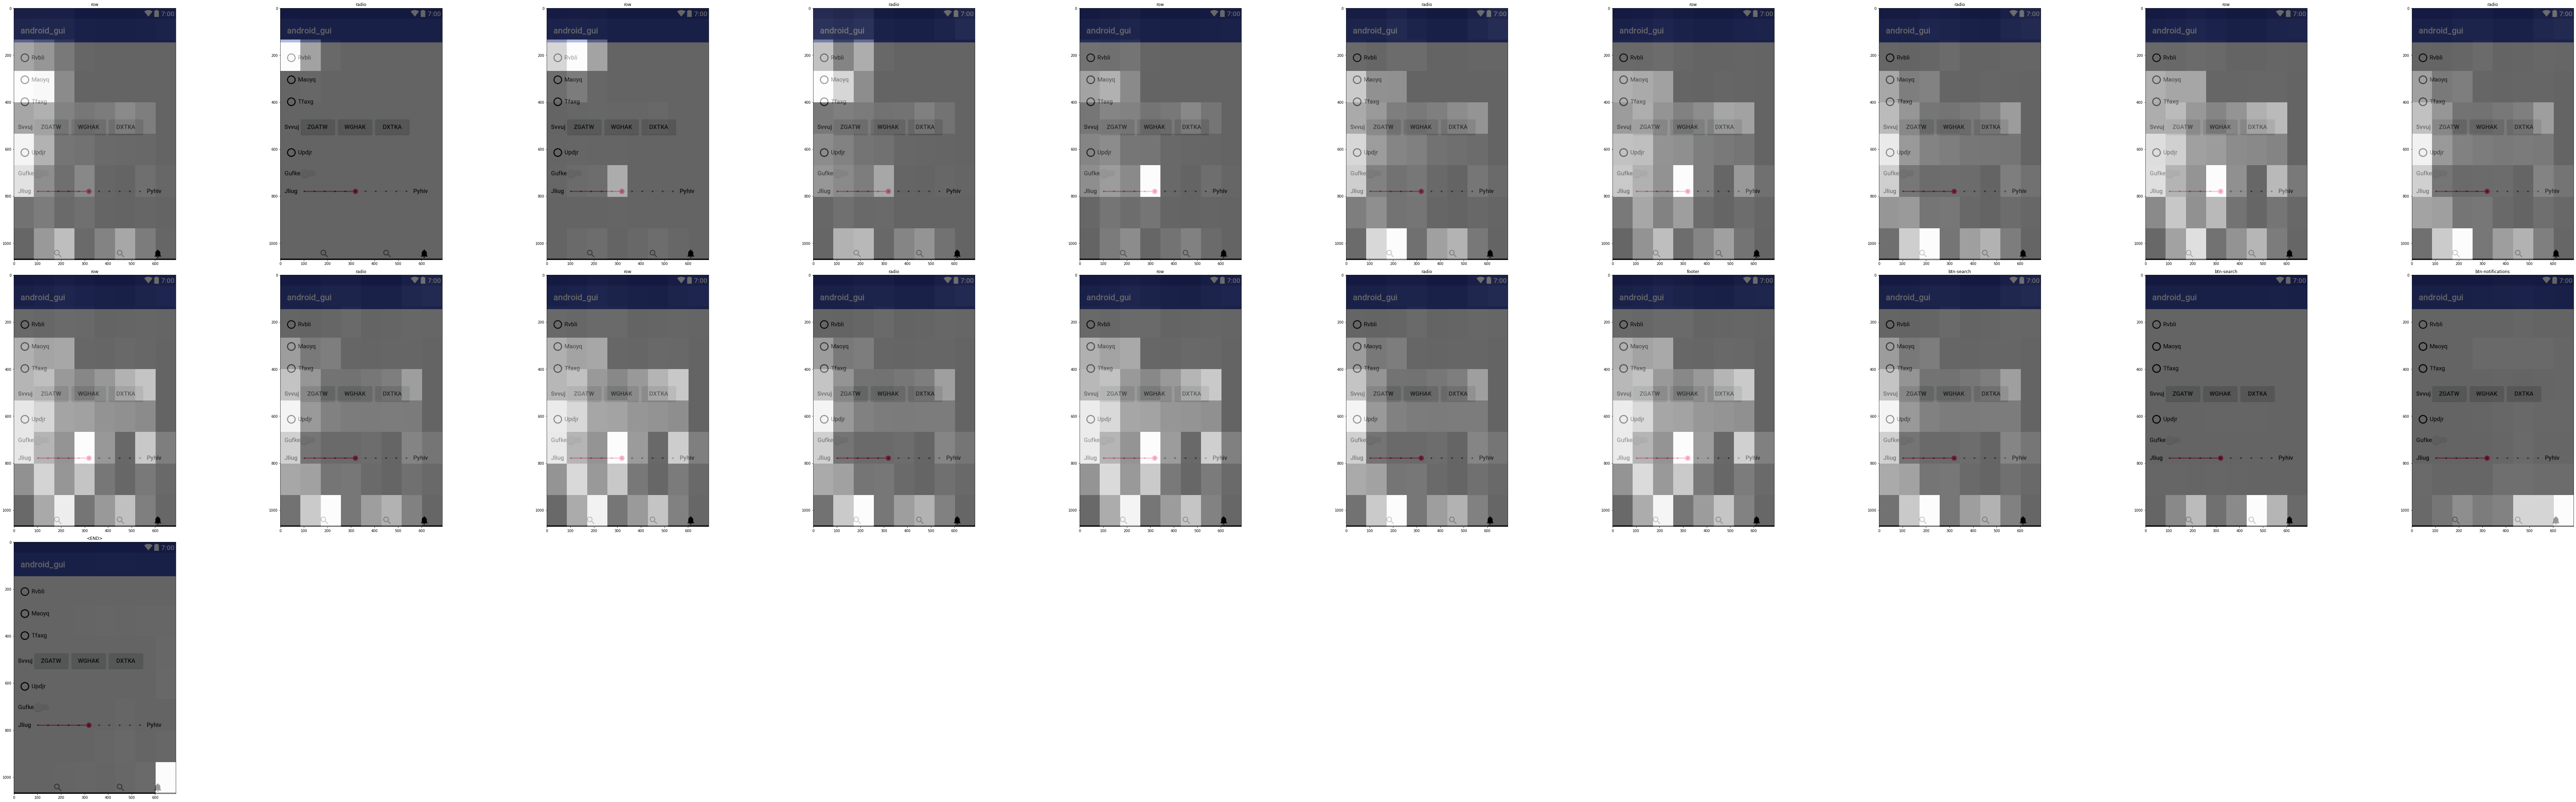

In [66]:
# captions on the validation set
rid = np.random.randint(0, eval_raw_dataset.size)

image = load_image(eval_raw_dataset.input_images[rid])
filename = eval_raw_dataset.ids[rid]
real_caption = ' '.join([eval_raw_dataset.voc.token_lookup[i] for i in eval_raw_dataset.total_sequences[rid]])

result, attention_plot = evaluate(image)

print("ID: {}".format(filename))
print ('Real Caption:', real_caption)
print ('Prediction Caption: <START>', ' '.join(result))


plot_attention("{}/{}.png".format(eval_path, filename), result, attention_plot*100)

## Word error rate - WER

- String edit distance - reconocimiento de texto 

In [67]:
def edit_distance(str1, str2, m, n): 
    # Create a table to store results of subproblems 
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] 
  
    # Fill d[][] in bottom up manner 
    for i in range(m + 1): 
        for j in range(n + 1): 
  
            # If first string is empty, only option is to 
            # insert all characters of second string 
            if i == 0: 
                dp[i][j] = j    # Min. operations = j 
  
            # If second string is empty, only option is to 
            # remove all characters of second string 
            elif j == 0: 
                dp[i][j] = i    # Min. operations = i 
  
            # If last characters are same, ignore last char 
            # and recur for remaining string 
            elif str1[i-1] == str2[j-1]: 
                dp[i][j] = dp[i-1][j-1] 
  
            # If last character are different, consider all 
            # possibilities and find minimum 
            else: 
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert 
                                   dp[i-1][j],        # Remove 
                                   dp[i-1][j-1])    # Replace 
  
    return dp[m][n] 

In [68]:
def wer(decode, target):
    """Computes the Word Error Rate (WER).
    WER is defined as the edit distance between the two provided sentences after
    tokenizing to words.
    Args:
    decode: string of the decoded output.
    target: a string for the ground truth label.
    Returns:
    A float number for the WER of the current decode-target pair."""
    
    # Map each word to a new char.
    words = set(decode.split() + target.split())
    word2char = dict(zip(words, range(len(words))))
    
    new_decode = [chr(word2char[w]) for w in decode.split()]
    new_target = [chr(word2char[w]) for w in target.split()]
    
    final_decode = ''.join(new_decode)
    final_target = ''.join(new_target)
    return edit_distance(final_decode,final_target, len(final_decode), len(final_target))

In [69]:
a = "<START> row label btn btn btn row switch <END>"
b= "<START> row label btn btn btn row label btn row label slider label <END>"
wer(a, b)

6

In [ ]:
sum_wer = 0

for rid in range(eval_raw_dataset.size):
    image = load_image(eval_raw_dataset.input_images[rid])
    filename = eval_raw_dataset.ids[rid]
    real_caption = ' '.join([eval_raw_dataset.voc.token_lookup[i] for i in eval_raw_dataset.total_sequences[rid]])
    result, attention_plot = evaluate(image)

    decode = '<START> ' + ' '.join(result)
    target = real_caption
    image_wer = wer(decode, target)
#     print(image_wer) 
    sum_wer += image_wer
total_wer = sum_wer / eval_raw_dataset.size
total_wer


## Resultados Loss WER

(15 epochs) 


- VGG fuera del LOOP con relu: 19.172, Loss 0.78 
- VGG en el LOOP con relu: 8.656, Loss 0.389

- VGG fuera del LOOP sin relu: 11.464, Loss 0.47
- VGG en el LOOP sin relu: 6.532, Loss 0.298
- VGG en el LOOP sin relu con Coordconv: 7.612, Loss:0.261

Early stopping de 0.001 (ultima y penultima)
- VGG en el LOOP sin relu: 4.676, Loss 0.183, (epoch 14), 80s/epoch
- VGG en el LOOP sin relu con Coordconv: 6.6, Loss:0.189 (epoch 16), 80s/epoch


## 1. Dataset

- _Sacar saltos de linea
- _stack { } footer { } -> START = stack{ ; END = } ; SPLIT = }footer{
- _Rehacer compilador
- Las imágenes deberían mantener el aspect ratio. (pintarlas!!)

## 2. Model

- Hacer el gráfico de nuevo - mandarlo.
- ENCODER

 - _Meter aquí la VGG.
 - _Probar a quitar relu en encoder: no hay cambios (quizá un poco de mejora)

- DECODER

- _Reshape entre fc (este reshape permite que la salida tenga dos dimensiones, PARA LA FUNCIÓN CATEGORICAL)
- _Falta relu!! : añadí una relu al final
- Probar con softmax - revisar.
- Añadir el CoordConv, añadiria a la imagen i,j (dentro de encoder o fuera?)

## 3. Training

- Hidden: inicializar con la media
- _Reducir Learning Rate

## 4. Evaluate

- _String edit distance - reconocimiento de texto (symbol (character) error rate)
- _Hacer función que analice todas: 
- Revisar con el mismo modelo me da distinto cada vez
- Revisar plot de los pesos - Attention.

## 5. Server

- _Plugins del VSCode para renderizar: encontré comando para convertir a script de Python, me falta probarlo
- Probar a hacer script de la notebook y usarlo en el server del cvc


## 6. Template TFM

- State of the Art (pix2code, s2s, image captioning)
- _Guión (para definir la semana que viene)
